In [1]:
### Loading Packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import os, random

import gc

import time

import os.path


# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# I don't know why I don't have permissions to this file, but this seems to fix the issue
!chmod 751 ~/notebook/work/Earthquake/train.csv

In [3]:
cd ~/notebook/work/Earthquake

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s55f-399db8dc89addb-a597b6337f26/notebook/work/Earthquake


## Loading the Data  
Let's get a quick look at the file before we read it.  This csv file has a header for two columns of data, 'acoustic_data', and 'time_to_failure'.  If I loaded this we would have a dataframe 9.4 GB object with 629,145,480 rows of int64 and float64 data.  This is probably too much.  The head of the data shows that time is measured out to 10 digits so sampling the data seems reasonable approach, at least for exploring the data.  Casting the values to shorter lenght float and integer types seems to be a common approach to saving memory in other kernels, but it just ends up rounding the time to failure data to discrete interval blocks.  I'm going to assume that the data has been collected and stored at a deliberate sampling rate and not mess around with that.  For now, I will sample a certain percentage of the entire train dataset for a birdseye view of the data.  

Here I also took a quick look at some of the test data which simply has one column 'acoustic_data'.  I'll try not to look at the test data too much so there is as little leakage as possible.  For now I'd just like enough information to be able to apply the same transformations to the test data as I do the training data.

In [4]:
!head -10 train.csv

acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744


In [5]:
!head -10 seg_0012b5.csv

acoustic_data
5
8
8
7
4
1
-1
-4
-1


In [6]:
def sample_csv(filename, nth_line):
    """
    Reads every nth line of a csv file
    If it is a training file, writes a csv file of this sampled data to 'filename_sample_' + nth_line+ 'nth.csv'
    If a sampled csv file exists, loads that instead of the original filename
    ex. if n = 100, every 100th line is read
    and a 1% sample is taken and 'filename_sample_100th.csv' is written
    https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-python-data-frame
    
    """
    sub_string = '.csv'
    insert_text = '_sample_' + str(nth_line) + 'th'
    index = filename.index(sub_string)
    sample_filename = filename[:index] + insert_text + filename[index:]
    if os.path.isfile(sample_filename):
        df = pd.read_csv(sample_filename, header = 0)
    else:
        df = pd.read_csv(filename, header = 0, skiprows = lambda i: i % nth_line != 0)
        # Write a sample file, but only for the large training file
        if 'train' in filename:
            df.to_csv(sample_filename, index=False)
    return df

In [7]:
%%time
nth_line = 100
train_filename = 'train.csv'
test_filename = random.choice(os.listdir()) #change dir name to whatever
while (('train' or 'sample') in test_filename and 'seg' not in test_filename): 
    test_filename = random.choice(os.listdir())
    
train_orig = sample_csv(train_filename, nth_line)
train = train_orig.copy()

test_orig = sample_csv(test_filename, nth_line)
test = test_orig.copy()

CPU times: user 1.64 s, sys: 236 ms, total: 1.88 s
Wall time: 2.07 s


In [8]:
train.head()

,acoustic_data,time_to_failure
0,9,1.469100
1,5,1.469100
2,0,1.469100
3,1,1.469100
4,1,1.469099


In [9]:
train.describe()

,acoustic_data,time_to_failure
count,6.291454e+06,6.291454e+06
mean,4.520574e+00,5.678293e+00
std,1.051612e+01,3.672698e+00
min,-3.196000e+03,9.552926e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173372e+00
max,4.088000e+03,1.610740e+01


In [10]:
test.head()

,acoustic_data
0,5
1,5
2,1
3,-4
4,0


In [11]:
test.describe()

,acoustic_data
count,1500.000000
mean,3.800667
std,5.546300
min,-35.000000
25%,1.000000
50%,4.000000
75%,6.000000
max,46.000000


## Plotting the Overview  
The acoustic data seems to be some sort of waveform and the time to failure looks like a sawtooth pattern.  What we are actually looking at is a stream of data showing 16 different failures.  The time to failure is zero when a failure occurs.  Incidentally, the acoustic data shows significant local peaks when the time to failure is zero.  I don't know if these peaks define a failure or if this is a labeled dataset.  The time to failure peaks at a value corresponding to the time between failures.  The sawtooth graph we are seeing actually should be a discontinuous set of lines all of the same negative slope but with different heights.  

The median difference between the time_to_failure is $1.1*10^-7$ and given the 1% sampling rate of original dataset, this means that sampling period of the original dataset should be about $1.1*10^-9$ or about one nano-second.  It would also seem as if diff(time_to_failure) is pretty uniform across three quartiles and we should only expect to see it vary more than the sampling period the 16 times there is a failure and there is a jump in the time_to_failure.

In [12]:
def plot_acoustic_ttf(df, interval = None):
    """
    Plots acoustic data and time_to_failure
    interval specifies range in df to plot, default is the whole df
    """
    if np.any(interval == None):
        interval = [0, len(df)-1]
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title('acoustic_data and time_to_failure')
    plt.plot(df['acoustic_data'].iloc[interval[0]:interval[1]], color = 'b')
    ax1.set_ylabel('acoustic_data', color = 'b')
    plt.legend(['acoustic_data'])
    ax2 = ax1.twinx()
    plt.plot(df['time_to_failure'].iloc[interval[0]:interval[1]], color = 'g')
    ax2.set_ylabel('time_to_failure', color = 'g')
    plt.legend(['time_to_failure'], loc = (0.875, 0.9))
    plt.grid(False)

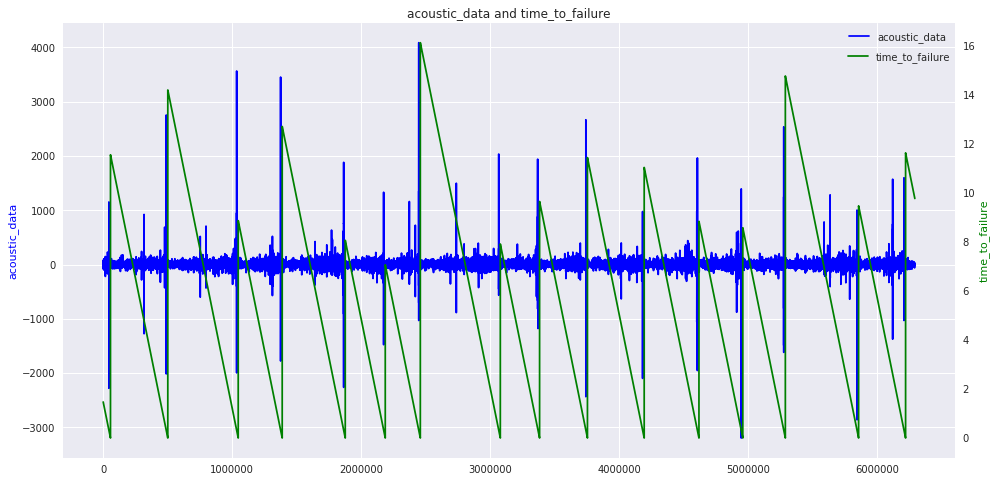

In [13]:
plot_acoustic_ttf(train)

In [14]:
train['time_to_failure'].diff().describe()

count    6.291453e+06
mean     1.317771e-06
std      1.760010e-02
min     -1.095606e-03
25%     -1.100000e-07
50%     -1.100000e-07
75%     -1.100000e-07
max      1.610690e+01
Name: time_to_failure, dtype: float64

### Locating Failures  
Locating where the failures occur in the dataset should help our analysis.  First a new column 'failure' is added to the dataframe that is true when a failure occurs and false otherwise.  Hopefully a clearer picture emerges when we zoom in on the graph and plot when failures occur.  

It would be useful to look at each of these failures as seperate events by introducing new time variables: ts for the overall time since the experiment started, and ts_local for each of the failure cycles. 

What becomes clear when you zoom in on the graph is that the acoustic data has a large peak shortly before the failures occur.  I suppose that must mean that this dataset is somehow labelled for when failures occur.  At first glance, it would appear that the time between when this large and failures is about the same for all of the failure cycles.  The length of each cycle can vary but this interval between peak acoustic and failure seems uniform.

There may also be an increasing trend in average magnitude of acoustic data as the cycle time increases.

 

In [15]:
def add_failure_column(df, threshold = 1):
    """
    Locates where failures occur by finding local minima of time_to_failure
    A local minima is found wherever the diff of consecutive values exceeds a threshold,
    ie. where there is a jump
    A new dataframe is returned with a new boolean column 'failure'
    For test datasets where there is no time_to_failure, all values set to False
    """
    # Turn off warning
    pd.options.mode.chained_assignment = None
    df['failure'] = False
    if 'time_to_failure' in df.columns:
        failures = df.loc[df['time_to_failure'].diff()>threshold].index-1
        df['failure'].loc[failures] = True
    return df

In [16]:
train = add_failure_column(train)
test = add_failure_column(test)

In [17]:
def add_time_columns(df):
    """
    adds columns ts and ts_local
    ts is time across the entire training set
    ts_local resets to zero after each failure
    IMPORTANT: The sampling frequency is not constant.  The recording device sends
    packets of 4096 points of evenly spaced samples
    and then puts a longer gap of time between packets.  
    """
    # compute diff of time_to_failure
    df['ts_diff'] = -df['time_to_failure'].diff().fillna(0)
    
    # need to get rid of this and just calculate things based off period
    # set diff at failures to previous datapoint diff
    failures = df.loc[df['failure']==True].index.tolist()
    for failure in failures:
        df['ts_diff'].iloc[failure+1] = df['ts_diff'].iloc[failure]
    # set ts to the cumsum of all the ts_diff
    df['ts'] = df['ts_diff'].cumsum()

    
    if 'time_to_failure' in df.columns:
        # compute diff of time_to_failure
        # somehow this loop resets the cumsum of ts_diff to zero after each failure
        df['ts_diff'] = -df['time_to_failure'].diff().fillna(0)
        ttf = [0] + failures
        del ttf[-1]
        for i in range(len(failures)):
            df['ts_diff'].iloc[failures[i]+1] = -df['time_to_failure'].iloc[ttf[i]+1]
        df['ts_local'] = df['ts_diff'].cumsum()

        df.drop(['ts_diff'], axis = 1, inplace = True)
    else:
        df['ts_local'] = df['ts'].copy()
    
    return df

In [18]:
train = add_time_columns(train)

In [19]:
def plot_failure(df, column = 'acoustic_data', nrows=1, interval=None, figsize = (18,6), ylim = None):
    """
    Plots column vs. failure, default is acoustic_data
    nrows is the number of subplots
    interval is an integer row index tuple or list for rows of data you wish to plot
    
    In case I forget why I used squeeze and 2-D axes arrays:
    # https://stackoverflow.com/questions/19953348/error-when-looping-to-produce-subplots
    """

    if np.any(interval == None):
        interval = [0, len(df)-1]

    df = df.iloc[interval[0]:interval[1]]
    sub_length = int(len(df)/nrows)
    fig, axes = plt.subplots(nrows,1, sharey= True, figsize = (figsize[0],figsize[1]*nrows), squeeze=False)
    for i in range(0,nrows):
        sub_range = range(i*sub_length,(i+1)*sub_length)
        axes[i,0].plot( df['ts'].iloc[sub_range], df[column].iloc[sub_range], color = 'b')
        axes[i,0].grid(False)
        if ylim is not None:
            axes[i,0].set_ylim(ylim)
        for failure in df.iloc[sub_range].loc[df['failure']==True].index:
            axes[i, 0].axvline(df['ts'].iloc[failure], color = 'r')
            
    return None

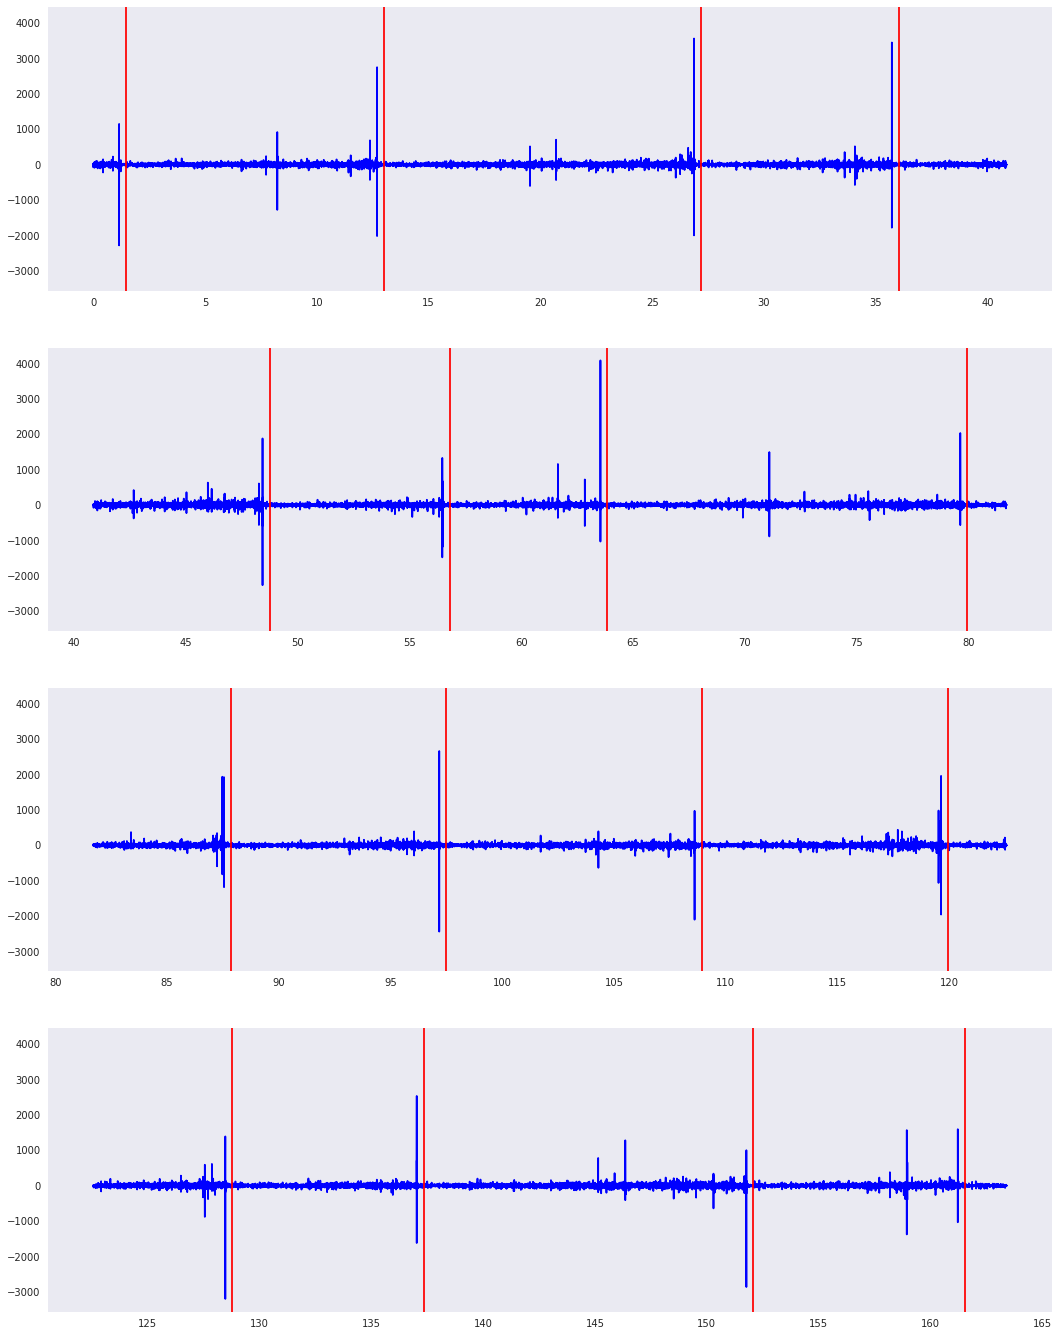

In [20]:
plot_failure(train, nrows = 4)

## Identify Quality Issues  
### Missing Values
There don't seem to be any null values in the data.  Keep in mind that this is a sample of only 1% of the data, but I suspect that there are no null values in the dataset.  If there are null values in acoustic_data or time_to_failure, filling in the values with interpolations of the adjacent valid data points would probably be a good strategy.

In [21]:
train.isnull().sum()

acoustic_data      0
time_to_failure    0
failure            0
ts                 0
ts_local           0
dtype: int64

### Outliers  
The outliers in the acoustic_data are enormous compared to the rest of the data, about 1000 times as large.  The case could be made that outliers signal an imminent failure and need to be preserved, but they certainly would mess up training a linear model.  Some sort of data transformation must be done, either to get rid of outliers or perhaps a log transformation.  Anyways, it is usually good practice to have your data fit a gaussian distribution.  
What is interesting about the data when plotted without outliers is that the median is about 5 and not zero.

#### Box Plot

In [22]:
def plot_boxplot(df, show_outliers = True):
    fig, ax = plt.subplots()
    if show_outliers:
        ax.set_title('acoustic_data')
    else:
        ax.set_title('acoustic_data, outliers excluded')
    ax.boxplot(df['acoustic_data'], showfliers= show_outliers)
    return None
    

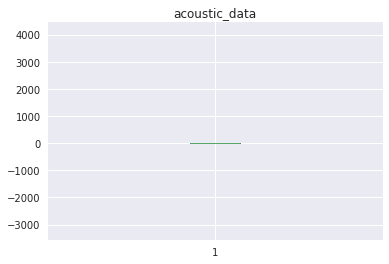

In [23]:
plot_boxplot(train)

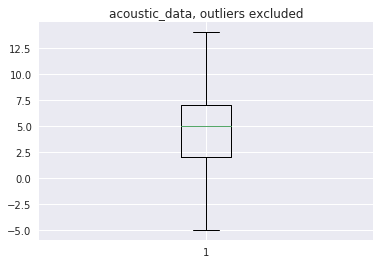

In [24]:
plot_boxplot(train, show_outliers = False)

#### Filter Outliers

In [25]:
def add_normal_outlier_columns(df, n_sigmas = 3, normal_alt_value = 0, outlier_alt_value = 0):
    """
    adds the columns ad_normal and ad_outlier
    corresponding to data that is either in the normal range or an outlier
    n_sigma default is 3 corresponding to 99.7% of data being in the normal range
    """
    df['normal'] = np.where(np.abs(df['acoustic_data']-df['acoustic_data'].mean()) 
                              <= (n_sigmas*df['acoustic_data'].std()), df['acoustic_data'], normal_alt_value)
    df['outlier'] = np.where(np.abs(df['acoustic_data']-df['acoustic_data'].mean()) 
                              > (n_sigmas*df['acoustic_data'].std()), df['acoustic_data'], outlier_alt_value)
    return df

In [26]:
train = add_normal_outlier_columns(train)

#### Histogram

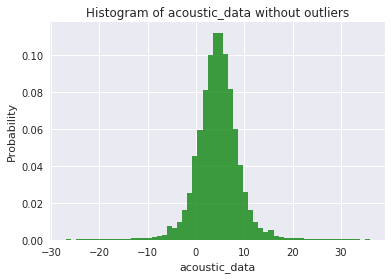

In [27]:
# the histogram of the data
n, bins, patches = plt.hist(train['normal'].fillna(0), bins = 60, density=1, facecolor='g', alpha=0.75)


plt.xlabel('acoustic_data')
plt.ylabel('Probability')
plt.title('Histogram of acoustic_data without outliers')
plt.show()

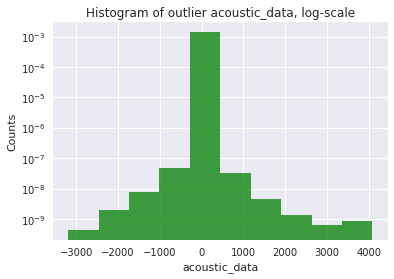

In [28]:
# the histogram of the data with outlier
n, bins, patches = plt.hist(train['outlier'].fillna(0), log = True, density = 1, facecolor='g', alpha=0.75)


plt.xlabel('acoustic_data')
plt.ylabel('Counts')
plt.title('Histogram of outlier acoustic_data, log-scale')
plt.show()

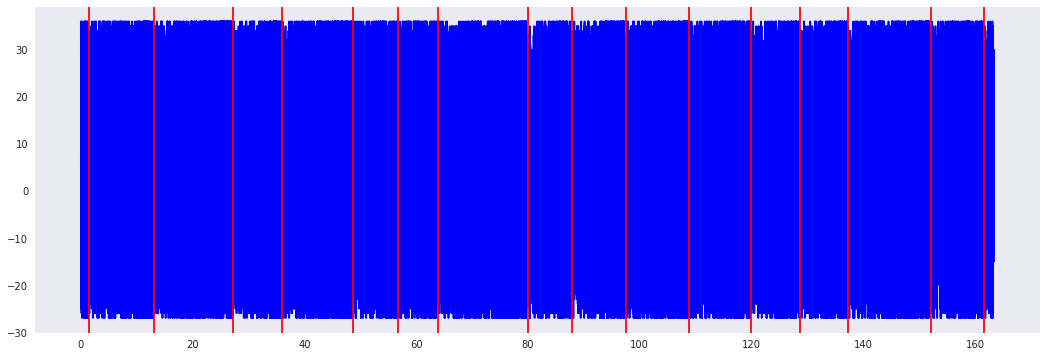

In [29]:
plot_failure(train, column = 'normal', nrows=1)

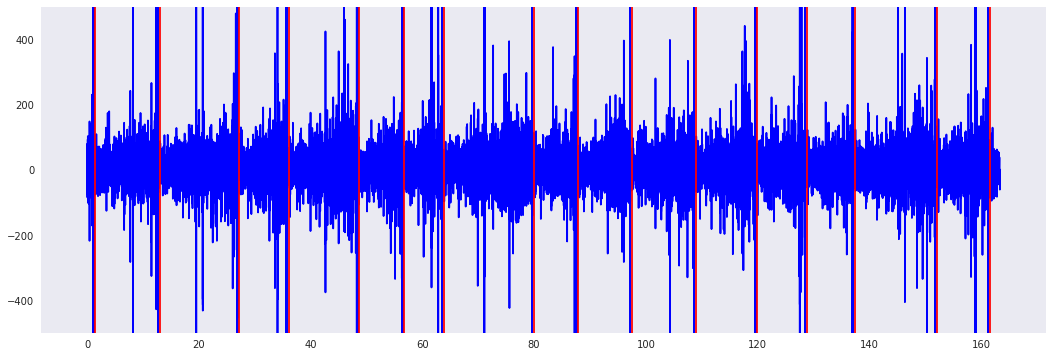

In [30]:
plot_failure(train, column = 'outlier', nrows=1, ylim = (-500, 500))

## Correllations  
There don't seem to be any promising correlations.  ts_local seems to have a good correlation with time_to_failure, but I just interpret this as saying failure is inevitable and the longer the experiment proceeds the greater the likelihood of failure.  Regardless, the test data doesn't have any time data so a model shouldn't be built around that.  I'll explore some rolling statistics to see if I can create features that correlate with time_to_failure

In [31]:
train.corrwith(train['time_to_failure'])

acoustic_data     -0.000528
time_to_failure    1.000000
failure           -0.002465
ts                -0.056206
ts_local          -0.689640
normal             0.001299
outlier           -0.001221
dtype: float64

### Explore rolling statistics  
Because the data appears almost sinusoidal, analyzing the magnitude of the waveforms seems reasonable.  Typically you'd expect the mean across a large enough window of a sinusoidal signal to equal zero, in our case the mean is 5.  I decided to study the magnitude centered around the mean.  Because we don't want data from before a failure occured to affect analysis before the next failure, it seems prudent to divide up the dataset into 'episodes'.  In our case we have 16 failures, but 17 episodes since that last episode did not result in a recorded failure.  
Because what we call outlier data can immediately and drastically affect rolling mean of acoustic_data something must be done to filter the outliers.  What I've done is apply what is effectively a low-pass filter, allowing only signals that fall within +/- 3 sigmas of the mean.  Signals outside of this band are clipped.  This seemed to increase the magnitude of correlations.  

In [32]:
train.describe()

,acoustic_data,time_to_failure,ts,ts_local,normal,outlier
count,6.291454e+06,6.291454e+06,6.291454e+06,6.291454e+06,6.291454e+06,6.291454e+06
mean,4.520574e+00,5.678293e+00,8.170563e+01,5.561306e+00,4.490876e+00,2.969886e-02
std,1.051612e+01,3.672698e+00,4.717315e+01,3.667135e+00,4.614661e+00,9.463632e+00
min,-3.196000e+03,9.552926e-05,-0.000000e+00,-9.428720e-03,-2.700000e+01,-3.196000e+03
25%,2.000000e+00,2.625997e+00,4.085302e+01,2.495918e+00,2.000000e+00,0.000000e+00
50%,5.000000e+00,5.349798e+00,8.170549e+01,5.219814e+00,4.000000e+00,0.000000e+00
75%,7.000000e+00,8.173372e+00,1.225582e+02,8.015395e+00,7.000000e+00,0.000000e+00
max,4.088000e+03,1.610740e+01,1.634112e+02,1.610114e+01,3.600000e+01,4.088000e+03


In [33]:
def add_deviation_columns(df):
    for col in ['acoustic_data', 'normal', 'outlier']:
        df[col+'_dev'] = np.abs(df[col]-df[col].mean())
    return df

In [34]:
train = add_deviation_columns(train)

In [35]:
del(train)
train = train_orig.copy()
train = add_failure_column(train)
train = add_time_columns(train)
train = add_normal_outlier_columns(train)
train = add_deviation_columns(train)
train.head()

,acoustic_data,time_to_failure,failure,ts,ts_local,normal,outlier,acoustic_data_dev,normal_dev,outlier_dev
0,9,1.469100,False,-0.000000e+00,-0.000000e+00,9,0,4.479426,4.509124,0.029699
1,5,1.469100,False,1.100000e-07,1.100000e-07,5,0,0.479426,0.509124,0.029699
2,0,1.469100,False,2.200000e-07,2.200000e-07,0,0,4.520574,4.490876,0.029699
3,1,1.469100,False,3.300000e-07,3.300000e-07,1,0,3.520574,3.490876,0.029699
4,1,1.469099,False,4.400000e-07,4.400000e-07,1,0,3.520574,3.490876,0.029699


In [36]:
def get_episodes(df):
    """
    Based on when failures occur, determines where episodes happen
    """
    # Locate when failures occur
    failures = df.loc[df['failure'] == True].index.tolist()

    # Determine episode intervals
    episodes = [range(0, failures[0]+1)]
    for time in range(0,len(failures)-1):
        episodes.append(range(failures[time]+1,failures[time+1]+1))
    episodes.append(range(failures[-1]+1, len(df)))
    
    return episodes

In [37]:
def add_rolling_mean_column(df, column = 'acoustic_data', windows = [100]):
    episodes = get_episodes(df)
    for win in windows:
        # Setup columns
        new_col_name = column + '_mean_' + str(win)
        rolling = []        
        for episode in episodes:
            series = df[column].iloc[episode]
            # Call the rolling Function
            rolling += (pd.Series(series).rolling(center = False, window = win).mean().tolist())
        # write column to dataframe
        df[new_col_name] = rolling
    return df

In [38]:
def add_rolling_std_column(df, column = 'acoustic_data', windows = [100]):
    episodes = get_episodes(df)
    for win in windows:
        # Setup columns
        new_col_name = column + '_std_' + str(win)
        rolling = []        
        for episode in episodes:
            series = df[column].iloc[episode]
            # Call the rolling Function
            rolling += (pd.Series(series).rolling(center = False, window = win).std().tolist())
        # write column to dataframe
        df[new_col_name] = rolling
    return df

In [39]:
def add_ewma_column(df, column = 'acoustic_data', center_of_mass = [100]):
    episodes = get_episodes(df)
    for center in center_of_mass:
        # Setup columns
        new_col_name = column + '_ewma_' + str(center)
        rolling = []        
        for episode in episodes:
            series = df[column].iloc[episode]
            # Call the rolling Function
            rolling += (pd.Series(series).ewm(com = center).mean().tolist())
        # write column to dataframe
        df[new_col_name] = rolling
    return df

In [40]:
%%time
for column in ['acoustic_data_dev', 'normal_dev', 'outlier_dev']:
    windows = [100, 1000, 10000, 100000]
    train = add_rolling_mean_column(train, column = column, windows = windows)
    train = add_rolling_std_column(train, column = column, windows = windows)
    train = add_ewma_column(train, column = column, center_of_mass = windows)

CPU times: user 1min 4s, sys: 18.6 s, total: 1min 23s
Wall time: 1min 23s


In [41]:
train.columns

Index(['acoustic_data', 'time_to_failure', 'failure', 'ts', 'ts_local',
       'normal', 'outlier', 'acoustic_data_dev', 'normal_dev', 'outlier_dev',
       'acoustic_data_dev_mean_100', 'acoustic_data_dev_mean_1000',
       'acoustic_data_dev_mean_10000', 'acoustic_data_dev_mean_100000',
       'acoustic_data_dev_std_100', 'acoustic_data_dev_std_1000',
       'acoustic_data_dev_std_10000', 'acoustic_data_dev_std_100000',
       'acoustic_data_dev_ewma_100', 'acoustic_data_dev_ewma_1000',
       'acoustic_data_dev_ewma_10000', 'acoustic_data_dev_ewma_100000',
       'normal_dev_mean_100', 'normal_dev_mean_1000', 'normal_dev_mean_10000',
       'normal_dev_mean_100000', 'normal_dev_std_100', 'normal_dev_std_1000',
       'normal_dev_std_10000', 'normal_dev_std_100000', 'normal_dev_ewma_100',
       'normal_dev_ewma_1000', 'normal_dev_ewma_10000',
       'normal_dev_ewma_100000', 'outlier_dev_mean_100',
       'outlier_dev_mean_1000', 'outlier_dev_mean_10000',
       'outlier_dev_mean_10

In [42]:
corr_acoustic = train[train.columns[10:22]].corrwith(train['time_to_failure'])
corr_acoustic.sort_values()

acoustic_data_dev_ewma_100000   -0.763673
acoustic_data_dev_ewma_10000    -0.707313
acoustic_data_dev_mean_100000   -0.677903
acoustic_data_dev_mean_10000    -0.635257
acoustic_data_dev_std_100000    -0.490074
acoustic_data_dev_ewma_1000     -0.388512
acoustic_data_dev_std_10000     -0.375553
acoustic_data_dev_mean_1000     -0.296824
acoustic_data_dev_std_1000      -0.190260
acoustic_data_dev_ewma_100      -0.175548
acoustic_data_dev_mean_100      -0.133246
acoustic_data_dev_std_100       -0.116824
dtype: float64

In [43]:
corr_normal = train[train.columns[22:34]].corrwith(train['time_to_failure'])
corr_normal.sort_values()

normal_dev_ewma_100000   -0.769273
normal_dev_ewma_10000    -0.764649
normal_dev_mean_10000    -0.741016
normal_dev_std_10000     -0.738197
normal_dev_mean_100000   -0.678088
normal_dev_std_100000    -0.673514
normal_dev_ewma_1000     -0.639385
normal_dev_mean_1000     -0.585027
normal_dev_std_1000      -0.571627
normal_dev_ewma_100      -0.456157
normal_dev_mean_100      -0.379038
normal_dev_std_100       -0.331151
dtype: float64

In [44]:
corr_outlier = train[train.columns[34:46]].corrwith(train['time_to_failure'])
corr_outlier.sort_values()

outlier_dev_ewma_100000   -0.699380
outlier_dev_mean_100000   -0.630762
outlier_dev_ewma_10000    -0.504008
outlier_dev_std_100000    -0.486110
outlier_dev_mean_10000    -0.427303
outlier_dev_std_10000     -0.376974
outlier_dev_ewma_1000     -0.208110
outlier_dev_std_1000      -0.194968
outlier_dev_mean_1000     -0.149418
outlier_dev_std_100       -0.101632
outlier_dev_ewma_100      -0.080181
outlier_dev_mean_100      -0.059464
dtype: float64

In [45]:
correlations = pd.DataFrame(pd.concat([corr_acoustic, corr_normal, corr_outlier]), columns = ['Correlation with time_to_failure'])
correlations.sort_values(by = 'Correlation with time_to_failure', ascending = True)

,Correlation with time_to_failure
normal_dev_ewma_100000,-0.769273
normal_dev_ewma_10000,-0.764649
acoustic_data_dev_ewma_100000,-0.763673
normal_dev_mean_10000,-0.741016
normal_dev_std_10000,-0.738197
acoustic_data_dev_ewma_10000,-0.707313
outlier_dev_ewma_100000,-0.699380
normal_dev_mean_100000,-0.678088
acoustic_data_dev_mean_100000,-0.677903
normal_dev_std_100000,-0.673514


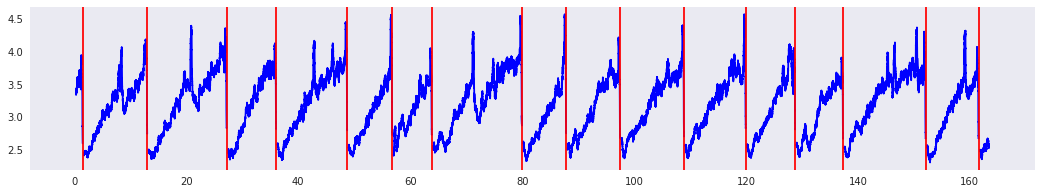

In [46]:
plot_failure(train, column = 'normal_dev_mean_10000', nrows=1, figsize = (18,3))

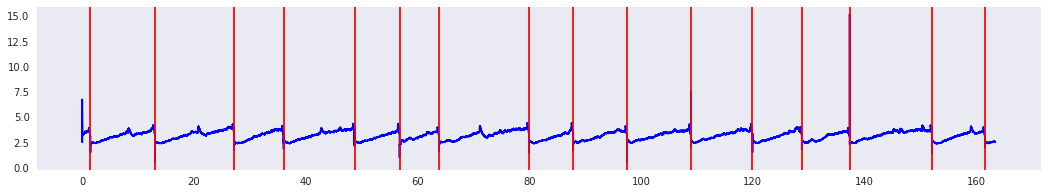

In [47]:
plot_failure(train, column = 'normal_dev_ewma_10000', nrows=1, figsize = (18,3))

## Fast Fourier Transform

In [48]:
from scipy import fftpack

### Generate the signal

In [49]:
np.abs(train['time_to_failure'].diff().median())

1.1000000021965661e-07

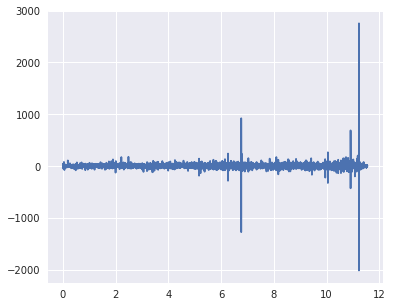

In [50]:
# time_step is the difference between consecutive time_to_failure rows
time_step = np.abs(train['time_to_failure'].diff().median())

episode_num = 1

episodes = get_episodes(train)
sig = train['acoustic_data'].iloc[episodes[episode_num]]
time_vec = train['ts_local'].iloc[episodes[episode_num]]
plt.figure(figsize = (6,5))
plt.plot(time_vec, sig, label = 'Original Signal')

### Compute and plot the power

%%time
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
# np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[pos_mask][:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

# Besides 41 Hz, the most powerful frequencies are in the megahertz range
freqs.max()

upper_lim = 10
plt.plot(freqs[:upper_lim], power[pos_mask][:upper_lim])


## To Do:
1. FFT  
2. GRU network
3. Wavelet